# Autocorrelation and Crosscorrelation
**Autocorrelation** measures the similarity between a time series and a lagged version of itself over successive time intervals. It helps in identifying repeating patterns or periodic signals within the data. 

**Crosscorrelation**, on the other hand, measures the similarity between two different time series as a function of the lag of one relative to the other. 

In the context of SSA, these metrics are useful for analysing the underlying structure and relationships within simulated time series data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tqdm
from sympy import sqrt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Import all the functions from the 'src' directory, we import all the functions from each module so we can use them straight away
from ssa_simulation import simulate_two_telegraph_model_systems
from ssa_analysis import *
from ssa_classification import *
%load_ext autoreload
%autoreload 2

We directly take data that was generated for a fixed mean

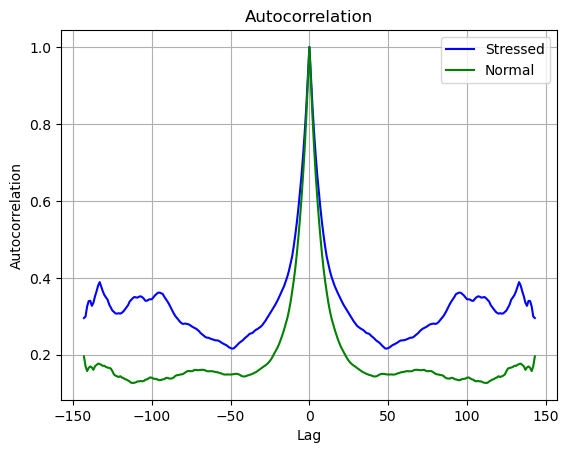

In [4]:
# Define system parameters
mu_target = 10.0  

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Stressed Condition
sigma_u_normal, sigma_b_normal = 9.0, 0.02   # Normal Condition

# Define degradation rates
d_stress = d_normal = 0.12

# Compute corresponding transcription rates (rho) using the given formula
rho_stress = (mu_target * d_stress * (sigma_u_stress + sigma_b_stress)) / sigma_b_stress
rho_normal = (mu_target * d_normal * (sigma_u_normal + sigma_b_normal)) / sigma_b_normal

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
]

output_file = "data/mRNA_trajectories_mean_fixed.csv"
df_results = pd.read_csv(output_file)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# Find the time index at which steady state is reached
steady_state_time_stress, steady_state_index_stress = find_steady_state(parameter_sets[0])
steady_state_time_normal, steady_state_index_normal = find_steady_state(parameter_sets[1])

# Extract steady-state portions
steady_state_traj_stress = stress_trajectories[:, steady_state_index_stress:]
steady_state_traj_normal = normal_trajectories[:, steady_state_index_normal:]

ac_stress, lags_stress = autocrosscorr(yA=steady_state_traj_stress)
ac_normal, lags_normal = autocrosscorr(yA=steady_state_traj_normal)
plt.figure()
plt.plot(lags_stress, np.nanmean(ac_stress, axis=0), color="blue", label="Stressed")
plt.plot(lags_normal, np.nanmean(ac_normal, axis=0), color="green", label="Normal")
plt.legend()
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation")
plt.grid()
plt.show()

Cross-correlation between 2 signals

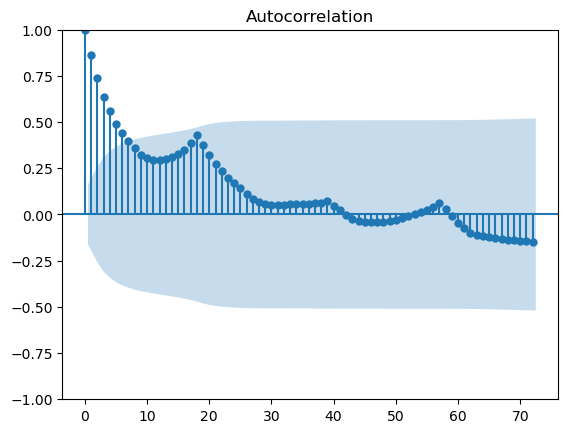

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
# mean_ss_traj_stress = np.mean(steady_state_traj_stress, axis=0)
# mean_ss_traj_normal = np.mean(steady_state_traj_normal, axis=0)

# ACF plot
plot_acf(steady_state_traj_normal[0, :], lags=len(steady_state_traj_normal[0, :])//2)
plt.show()

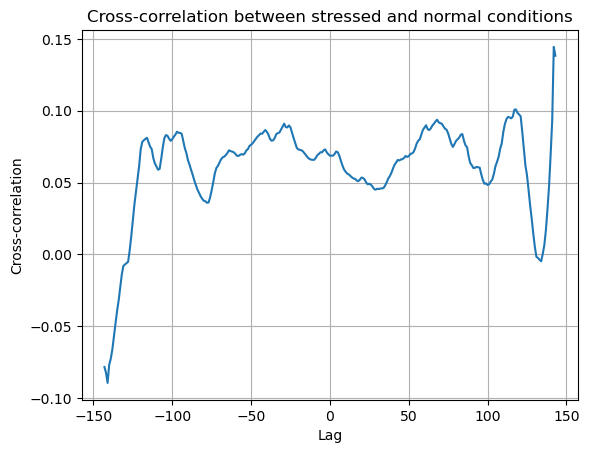

In [7]:
# Find and plot the cross-correlation between the two conditions
ac, lags = autocrosscorr(yA=steady_state_traj_normal, yB=steady_state_traj_stress)
plt.figure()
plt.plot(lags, np.nanmean(ac, axis=0))
plt.xlabel("Lag")
plt.ylabel("Cross-correlation")
plt.title("Cross-correlation between stressed and normal conditions")
plt.grid()
plt.show()


Fixing the Autocorrelation using the right equation

In [ ]:
import numpy as np

def autocrosscorr_updated(t_max, num_points, d, sigma_u, sigma_b, rho, only_pos=False):
    """
    Calculate autocorrelation of mRNA levels based on the given mathematical formula.

    Parameters
    ----------
    t_max : float
        Maximum absolute lag time to consider.
    num_points : int
        Number of time points to evaluate.
    d : float
        Degradation rate.
    sigma_u : float
        Gene off rate.
    sigma_b : float
        Gene on rate.
    rho : float
        Transcription rate.
    only_pos : boolean (optional)
        If True, return results only for positive lags.

    Returns
    -------
    corr : array
        Autocorrelation values for each lag.
    lags : array
        A 1D array of the lags.
    """

    # Generate symmetric time points for both positive and negative lags
    t_values = np.linspace(-t_max, t_max, num_points)

    # Compute the denominator (remains constant for all time points)
    denominator = (d - sigma_u - sigma_b) * (rho * sigma_u + d * (sigma_u + sigma_b) + (sigma_u + sigma_b) ** 2)
    # prevent division by zero
    denominator = np.where(denominator == 0, 1e-10, denominator)  # Prevent division by zero

    # Compute autocorrelation for each lag
    corr = np.array([
        np.exp(-d * t) * (
            d * np.exp((d - sigma_u - sigma_b) * t) * rho * sigma_u
            - (sigma_u + sigma_b) * (-d**2 + rho * sigma_u + (sigma_u + sigma_b) ** 2)
        ) / denominator
        for t in t_values
    ])

    # Define lags (same length as corr)
    lags = np.linspace(-t_max, t_max, num_points)

    # Return only positive lags if specified
    if only_pos:
        midpoint = len(corr) // 2
        return corr[midpoint:], lags[midpoint:]
    else:
        return corr, lags

/tmp/ipykernel_257688/706066489.py:43: RuntimeWarning: overflow encountered in exp
  d * np.exp((d - sigma_u - sigma_b) * t) * rho * sigma_u
/tmp/ipykernel_257688/706066489.py:43: RuntimeWarning: overflow encountered in scalar multiply
  d * np.exp((d - sigma_u - sigma_b) * t) * rho * sigma_u


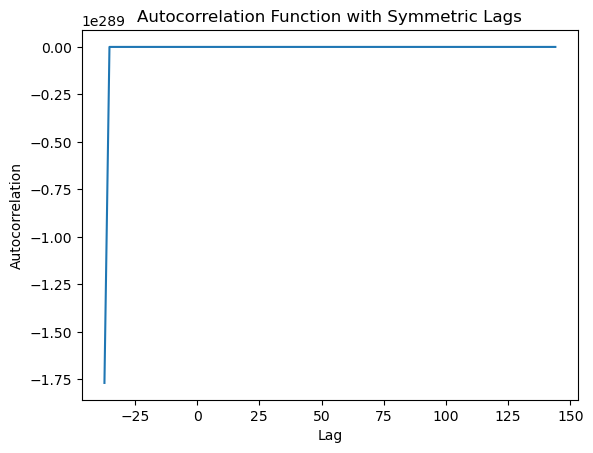

In [ ]:
# Define system parameters
mu_target = 10.0  

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Stressed Condition

# Define degradation rates
d_stress = 0.12

# Compute corresponding transcription rates (rho) using the given formula
rho_stress = (mu_target * d_stress * (sigma_u_stress + sigma_b_stress)) / sigma_b_stress

t_max = 144      # Maximum time lag to compute
num_points = 144  # Number of time points to compute

# Compute autocorrelation
corr, lags = autocrosscorr_updated(t_max, num_points, d_stress, sigma_u_stress, sigma_b_stress, rho_stress)

# Plot the results
plt.plot(lags, corr)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function with Symmetric Lags")
plt.show()

In [2]:
def autocrosscorr(
    yA,
    yB=None,
    stationary=False,
    normalised=True,
    only_pos=False,
):
    """
    Calculate normalised auto- or cross-correlations as a function of lag.

    Lag is given in multiples of the unknown time interval between data
    points, and normalisation is by the product of the standard
    deviation over time for each replicate for each variable.

    For the cross-correlation between sA and sB, the closest peak to zero
    lag should be in the positive lags if sA is delayed compared to
    signal B and in the negative lags if sA is advanced compared to
    signal B.

    Parameters
    ----------
    yA: array
        An array of signal values, with each row a replicate measurement
        and each column a time point.
    yB: array (required for cross-correlation only)
        An array of signal values, with each row a replicate measurement
        and each column a time point.
    stationary: boolean
        If True, the underlying dynamic process is assumed to be
        stationary with the mean a constant, estimated from all
        data points.
    normalised: boolean (optional)
        If True, normalise the result for each replicate by the standard
        deviation over time for that replicate.
    only_pos: boolean (optional)
        If True, return results only for positive lags.

    Returns
    -------
    corr: array
        An array of the correlations with each row the result for the
        corresponding replicate and each column a time point
    lags: array
        A 1D array of the lags in multiples of the unknown time interval

    Example
    -------
    >>> import matplotlib.pyplot as plt
    >>> import numpy as np

    Define a sine signal with 200 time points and 333 replicates

    >>> t = np.linspace(0, 4, 200)
    >>> ts = np.tile(t, 333).reshape((333, 200))
    >>> s = 3*np.sin(2*np.pi*ts + 2*np.pi*np.random.rand(333, 1))

    Find and plot the autocorrelaton

    >>> ac, lags = autocrosscorr(s)
    >>> plt.figure()
    >>> plt.plot(lags, np.nanmean(ac, axis=0))
    >>> plt.show()

    Reference
    ---------
    Dunlop MJ, Cox RS, Levine JH, Murray RM, Elowitz MB (2008). Regulatory
    activity revealed by dynamic correlations in gene expression noise.
    Nat Genet, 40, 1493-1498.
    """
    # number of replicates & number of time points
    nr, nt = yA.shape
    # autocorrelation
    if yB is None:
        yB = yA
    # find deviation from the mean
    dyA, stdA = _dev(yA, nr, nt, stationary)
    dyB, stdB = _dev(yB, nr, nt, stationary)
    # calculate correlation
    # lag r runs over positive lags
    pos_corr = np.nan * np.ones(yA.shape)
    for r in range(nt):
        prods = [dyA[:, t] * dyB[:, t + r] for t in range(nt - r)]
        pos_corr[:, r] = np.nanmean(prods, axis=0)
    # lag r runs over negative lags
    # use corr_AB(-k) = corr_BA(k)
    neg_corr = np.nan * np.ones(yA.shape)
    for r in range(nt):
        prods = [dyB[:, t] * dyA[:, t + r] for t in range(nt - r)]
        neg_corr[:, r] = np.nanmean(prods, axis=0)
    if normalised:
        # normalise by standard deviation
        pos_corr = pos_corr / stdA / stdB
        neg_corr = neg_corr / stdA / stdB
    # combine lags
    lags = np.arange(-nt + 1, nt)
    corr = np.hstack((np.flip(neg_corr[:, 1:], axis=1), pos_corr))
    # return correlation and lags
    if only_pos:
        return corr[:, int(lags.size / 2) :], lags[int(lags.size / 2) :]
    else:
        return corr, lags

def _dev(y, nr, nt, stationary=False):
    # calculate deviation from the mean
    if stationary:
        # mean calculated over time and over replicates
        dy = y - np.nanmean(y)
    else:
        # mean calculated over replicates at each time point
        dy = y - np.nanmean(y, axis=0).reshape((1, nt))
    # standard deviation calculated for each replicate
    stdy = np.sqrt(np.nanmean(dy**2, axis=1).reshape((nr, 1)))
    return dy, stdy